In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import mediapipe as mp
from tqdm import tqdm
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, phase, grayscale_transform=None, color_transform=None):
        self.grayscale_dir = os.path.join(root_dir, phase, 'grayscale')
        self.color_dir = os.path.join(root_dir, phase, 'color')
        self.grayscale_transform = grayscale_transform
        self.color_transform = color_transform
        self.image_names = [f for f in os.listdir(self.grayscale_dir) if os.path.isfile(os.path.join(self.grayscale_dir, f))]
        
        # Collect labels
        self.labels = []
        self.valid_image_names = []
        for filename in self.image_names:
            if filename.startswith('grayscale_') or filename.startswith('color_'):
                parts = filename.split('_')
                try:
                    label = int(parts[1])
                    self.labels.append(label)
                    self.valid_image_names.append(filename)
                except ValueError:
                    continue
        
        self.image_names = self.valid_image_names

        # Create continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_path = os.path.join(self.grayscale_dir, self.image_names[idx])
        color_path = os.path.join(self.color_dir, self.image_names[idx])

        grayscale_image = Image.open(grayscale_path).convert('L')
        color_image = Image.open(color_path).convert('RGB')

        if self.grayscale_transform:
            grayscale_image = self.grayscale_transform(grayscale_image)
        if self.color_transform:
            color_image = self.color_transform(color_image)

        label = self.labels[idx]
        return grayscale_image, color_image, label

grayscale_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

color_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
# Create dataset instances
root_dir = 'dataset5_dual_data'
train_dataset = PairedImageDataset(root_dir, 'train', grayscale_transform, color_transform)
val_dataset = PairedImageDataset(root_dir, 'val', grayscale_transform, color_transform)
test_dataset = PairedImageDataset(root_dir, 'test', grayscale_transform, color_transform)

# Create dataloader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Model definition
class DualInputCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(DualInputCNN, self).__init__()

        # Grayscale CNN
        self.grayscale_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )

        # Color CNN (after MediaPipe processing)
        self.color_cnn = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(50, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(32*3*3 + 64*12*12, 512)
        self.fc_dropout = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(512, num_classes)  # Assuming 10 classes

    def forward(self, grayscale, color):
        # Grayscale pathway
        x1 = self.grayscale_cnn(grayscale)
        x1 = x1.view(-1, 32 * 3 * 3)

        # Color pathway
        x2 = self.color_cnn(color)
        print(x2.shape)
        x2 = x2.view(-1, 64*12*12)

        # Concatenate and classify
        x = torch.cat((x1, x2), dim=1)
        x = self.fc_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [23]:
def process_with_mediapipe(color_images):
    batch_landmarks = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
        # If no landmarks found, append zero landmarks
        if not landmarks:
            landmarks = np.zeros((21, 3))
        batch_landmarks.append(landmarks)
    return torch.tensor(batch_landmarks, dtype=torch.float32)


In [24]:
# Initialize MediaPipe
mp_hands = mp.solutions.hands.Hands(static_image_mode=True)

# Model, Loss, Optimizer
model = DualInputCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Training')

    for data in train_progress_bar:
        grayscale_images, color_images, labels = data

        # Process color images with MediaPipe
        color_images = process_with_mediapipe(color_images)
        print(color_images.shape)

        optimizer.zero_grad()
        outputs = model(grayscale_images, color_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_progress_bar.set_postfix({'loss': running_loss / (train_progress_bar.n + 1)})

    # Validation step
    model.eval()
    val_loss = 0.0
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Validation')

    with torch.no_grad():
        for data in val_progress_bar:
            grayscale_images, color_images, labels = data

            # Process color images with MediaPipe
            color_images = process_with_mediapipe(color_images)

            outputs = model(grayscale_images, color_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_progress_bar.set_postfix({'val_loss': val_loss / (val_progress_bar.n + 1)})

    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}, Validation loss: {val_loss / len(val_loader):.3f}')

print('Finished Training')


I0000 00:00:1717264933.265698 3112358 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1717264933.276815 3120458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717264933.287944 3120458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Epoch 1/10 Training:   0%|                             | 0/1439 [00:00<?, ?it/s]

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
torch.Size([32, 3, 224, 224])


Epoch 1/10 Training:   0%|                             | 0/1439 [00:02<?, ?it/s]

torch.Size([32, 25, 56, 56])


RuntimeError: shape '[-1, 9216]' is invalid for input of size 2508800

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


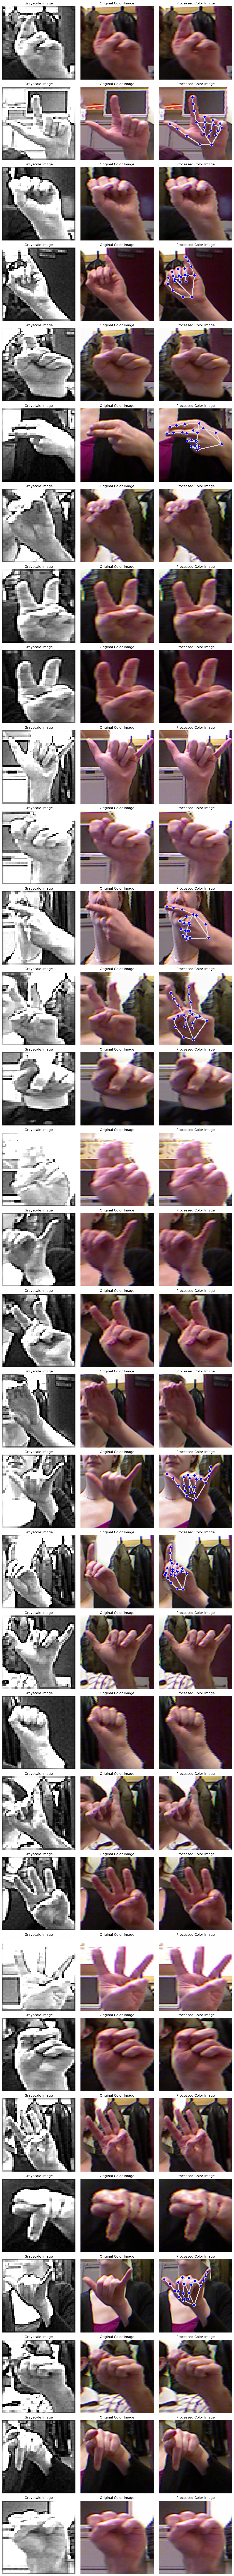

In [25]:
import matplotlib.pyplot as plt

# Create batch of landmark processed images - full image annotation
def process_with_mediapipe(color_images):
    processed_images = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    color_image_np, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
        color_image_np = color_image_np.astype(np.float32) / 255.0  # Convert back to float32
        processed_images.append(torch.tensor(color_image_np).permute(2, 0, 1))
    return torch.stack(processed_images)



# Function to visualize a batch of images
def visualize_batch(grayscale_images, color_images, processed_color_images):
    batch_size = grayscale_images.size(0)

    fig, axes = plt.subplots(batch_size, 3, figsize=(12, batch_size * 4))
    for i in range(batch_size):
        # Grayscale image
        axes[i, 0].imshow(grayscale_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Grayscale Image')
        axes[i, 0].axis('off')

        # Original color image
        axes[i, 1].imshow(color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title('Original Color Image')
        axes[i, 1].axis('off')

        # Processed color image with MediaPipe landmarks
        axes[i, 2].imshow(processed_color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title('Processed Color Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Fetch a single batch of images from the DataLoader
data_iter = iter(train_loader)
grayscale_images, color_images, labels = next(data_iter)

# Process color images with MediaPipe
processed_color_images = process_with_mediapipe(color_images)

# Visualize the batch
visualize_batch(grayscale_images, color_images, processed_color_images)
